https://pvlib-python.readthedocs.io/en/latest/forecasts.html

pvlib-python provides a set of functions and classes that make it easy to obtain weather forecast data and convert that data into a PV power forecast. Users can retrieve standardized weather forecast data relevant to PV power modeling from NOAA/NCEP/NWS models including the GFS, NAM, RAP, HRRR, and the NDFD. A PV power forecast can then be obtained using the weather data as inputs to the comprehensive modeling capabilities of PVLIB-Python. Standardized, open source, reference implementations of forecast methods using publicly available data may help advance the state-of-the-art of solar power forecasting.

pvlib-python uses Unidata’s Siphon library to simplify access to real-time forecast data hosted on the Unidata THREDDS catalog. Siphon is great for programatic access of THREDDS data, but we also recommend using tools such as Panoply to easily browse the catalog and become more familiar with its contents.

We do not know of a similarly easy way to access archives of forecast data.

This document demonstrates how to use pvlib-python to create a PV power forecast using these tools. The forecast and forecast_to_power Jupyter notebooks provide additional example code.


https://anaconda.org/conda-forge/siphon   

A collection of Python utilities for accessing remote geoscience data

conda install -c conda-forge siphon
    
conda install -c conda-forge/label/cf201901 siphon 

https://anaconda.org/pvlib/pvlib      

 conda install -c pvlib pvlib  // or   https://pvlib-python.readthedocs.io/en/latest/installation.html

Description

PVLIB Python is a community supported tool that provides a set of functions and classes for simulating the performance of photovoltaic energy systems. PVLIB Python was originally ported from the PVLIB MATLAB toolbox developed at Sandia National Laboratories and it implements many of the models and methods developed at the Labs. More information on Sandia Labs PV performance modeling programs can be found at https://pvpmc.sandia.gov/. We collaborate with the PVLIB MATLAB project, but operate independently of it.

We need your help to make pvlib-python a great tool!

Documentation: http://pvlib-python.readthedocs.io

Source code: https://github.com/pvlib/pvlib-python


In [37]:
import pandas as pd

import matplotlib.pyplot as plt

import datetime

import siphon

In [38]:
#import pvlib forecast models
# from pvlib.forecast  import GFS, NAM, NDFD, HRRR, RAP
from pvlib.forecast  import GFS

Fore example: Sapporo City in Hokkaido, Japan

43.0621° N, 141.3544° E

#Caculate the mean of the coordination of PV systems in Hokkaido

From file: LD_DETAIL_EN_excel.docx

Data 1: Targeted Solar Power Plants

S1: lat=42.7169, lng=141.6920625

S2: lat=43.12896, lng=144.1081429

mean(S1,S2):lat=42.90919333, lng=142.8195667

Data2: Measurement Locations (Temperature and Global Solar Radiation Values)

S1: lat=42.8769, lng=141.54755

S2: lat=43.3968, lng=144.15215

mean(S1,S2):lat=43.136825, lng=142.84985


In [39]:
# specify location (Tucson, AZ)
latitude, longitude, tz = 32.2, -110.9, 'US/Arizona'


####### Hokkaido Location S1 Measurements
# latitude, longitude, tz = 42.88, 141.55, 'Japan'
# latitude, longitude, tz = 42.72, 141.69, 'Japan'

##### Misurata Libya
# latitude, longitude, tz = 32.3256, 15.0993, 'Libya'

In [40]:
# specify time range.
start = pd.Timestamp(datetime.date.today(), tz=tz)

end = start + pd.Timedelta(days=7)

irrad_vars = ['ghi', 'dni', 'dhi']
 
print(start, end)
tz

2019-02-23 00:00:00-07:00 2019-03-02 00:00:00-07:00


'US/Arizona'

Different dates from the past with Japan time zone

https://stackoverflow.com/questions/17159207/change-timezone-of-date-time-column-in-pandas-and-add-as-hierarchical-index

In [41]:
# start=pd.Timestamp(2018, 12, 1, 12)
start=pd.Timestamp(2019, 1, 23, 12)
start=start.tz_localize('UTC').tz_convert(tz)

# end=pd.Timestamp(2018, 12, 31, 12)
# end=end.tz_localize('UTC').tz_convert(tz)

end = start + pd.Timedelta(days=7)

irrad_vars = ['ghi', 'dni', 'dhi']
 
print(start, end)
tz

2019-01-23 05:00:00-07:00 2019-01-30 05:00:00-07:00


'US/Arizona'

Next, we instantiate a GFS model object and get the forecast data from Unidata.

It will be useful to process this data before using it with pvlib. For example, the column names are non-standard, the temperature is in Kelvin, the wind speed is broken into east/west and north/south components, and most importantly, most of the irradiance data is missing. The forecast module provides a number of methods to fix these problems.

In [42]:
model = GFS()
data = model.get_processed_data(latitude, longitude, start, end)

print(data.head())

                           temp_air  wind_speed         ghi         dni  \
2019-01-24 03:00:00-07:00  6.716522    2.701736    0.000000    0.000000   
2019-01-24 06:00:00-07:00  4.612366    1.486167    0.000000    0.000000   
2019-01-24 09:00:00-07:00  3.270050    0.805915  271.932697  752.841956   
2019-01-24 12:00:00-07:00  1.440826    0.732997  654.572948  927.082296   
2019-01-24 15:00:00-07:00  2.393524    1.735582  481.593183  882.969001   

                                 dhi  total_clouds  low_clouds  mid_clouds  \
2019-01-24 03:00:00-07:00   0.000000           0.0         0.0         0.0   
2019-01-24 06:00:00-07:00   0.000000           0.0         0.0         0.0   
2019-01-24 09:00:00-07:00  49.237357           0.0         0.0         0.0   
2019-01-24 12:00:00-07:00  84.354944           0.0         0.0         0.0   
2019-01-24 15:00:00-07:00  64.962899           0.0         0.0         0.0   

                           high_clouds  
2019-01-24 03:00:00-07:00          0.0 

Plot the outputs of forecast models, such as solar irradiance components, clouds, etc. (They are useful for solar power forecast).

For example GFS, a global mode:

The Global Forecast System (GFS) is the US model that provides forecasts for the entire globe. The GFS is updated every 6 hours. The GFS is run at two resolutions, 0.25 deg and 0.5 deg, and is available with 3 hour time resolution. Forecasts from GFS model were shown above. Use the GFS, among others, if you want forecasts for 1-7 days or if you want forecasts for anywhere on Earth.



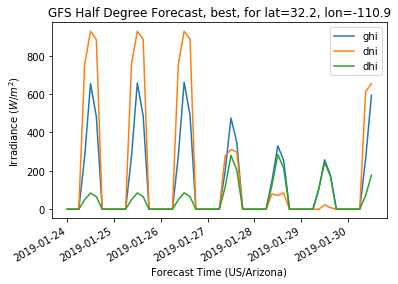

In [43]:
# In [50]: model = HRRR()
# data = model.get_processed_data(latitude, longitude, start, end)
model = GFS()
data[irrad_vars].plot();

plt.ylabel('Irradiance ($W/m^2$)');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('{}, for lat={}, lon={}'.format(model, latitude, longitude));
plt.legend();

# Cloud cover and radiation

All of the weather models currently accessible by pvlib include one or more cloud cover forecasts. For example, below we plot the GFS cloud cover forecasts

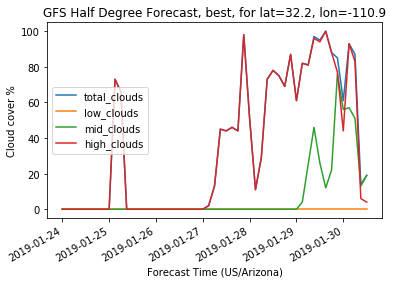

In [44]:
# plot cloud cover percentages
cloud_vars = ['total_clouds', 'low_clouds','mid_clouds', 'high_clouds']
data[cloud_vars].plot();
plt.ylabel('Cloud cover %');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('{}, for lat={}, lon={}'.format(model, latitude, longitude));
plt.legend();

# Extract solar radiation from cloud cover infromataion:
However, many of forecast models do not include radiation components in their output fields, or if they do then the radiation fields suffer from poor solar position or radiative transfer algorithms. It is often more accurate to create empirically derived radiation forecasts from the weather models’ cloud cover forecasts.

PVLIB-Python provides two basic ways to convert cloud cover forecasts to irradiance forecasts. One method assumes a linear relationship between cloud cover and GHI, applies the scaling to a clear sky climatology, and then uses the DISC model to calculate DNI. The second method assumes a linear relationship between cloud cover and atmospheric transmittance, and then uses the Liu-Jordan [Liu60] model to calculate GHI, DNI, and DHI.

Note: these algorithms are not rigorously verified! The purpose of the forecast module is to provide a few exceedingly simple options for users to play with before they develop their own models. We strongly encourage pvlib users first read the source code and second to implement new cloud cover to irradiance algorithms.

The essential parts of the clear sky scaling algorithm are as follows. Clear sky scaling of climatological GHI is also used in Larson et. al. [Lar16].

In [45]:
#### model.cloud_cover_to_irradiance
# solpos = location.get_solarposition(cloud_cover.index)
# cs = location.get_clearsky(cloud_cover.index, model='ineichen')
# # offset and cloud cover in decimal units here
# # larson et. al. use offset = 0.35
# ghi = (offset + (1 - offset) * (1 - cloud_cover)) * ghi_clear
# dni = disc(ghi, solpos['zenith'], cloud_cover.index)['dni']
# dhi = ghi - dni * np.cos(np.radians(solpos['zenith']))

In [46]:
import os
import itertools
import matplotlib.pyplot as plt
import pandas as pd
import pvlib
from pvlib import clearsky, atmosphere, solarposition
from pvlib.location import Location
# from pvlib.iotools import read_tmy3

In [47]:
# location = Location(latitude, longitude, tz, 700, 'Japan')
# # location=Location(32.2, -111, 'US/Arizona', 700, 'Tucson')
# # times = pd.DatetimeIndex(start='2016-12-01', end='2018-12-04', freq='1min', tz=location.tz)
# times = pd.DatetimeIndex(start='2016-07-01', end='2016-07-04', freq='1min', tz=location.tz)

# cs = location.get_clearsky(times)  # ineichen with climatology table by default
# # cs.describe()

In [48]:
# cs.plot();
# # plt.ylabel('Irradiance $W/m^2$');
# # plt.title('Ineichen, climatological turbidity');

In [49]:
raw_data = model.get_data(latitude, longitude, start, end)
# plot irradiance data
data = model.rename(raw_data)
irrads = model.cloud_cover_to_irradiance(data['total_clouds'], how='clearsky_scaling')

The figure below shows the result of the total cloud cover to irradiance conversion using the clear sky scaling algorithm

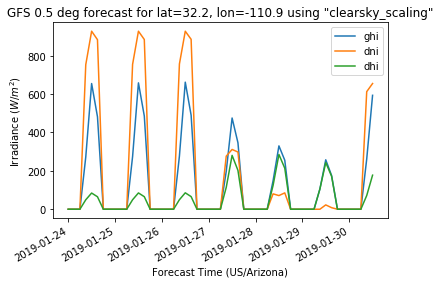

In [50]:
irrads.plot();
plt.ylabel('Irradiance ($W/m^2$)');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('GFS 0.5 deg forecast for lat={}, lon={} using "clearsky_scaling"'.format(latitude, longitude));

plt.legend();

The essential parts of the Liu-Jordan cloud cover to irradiance algorithm are as follows.

The figure below shows the result of the Liu-Jordan total cloud cover to irradiance conversion.

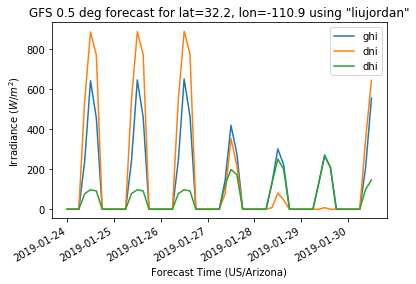

In [51]:
# plot irradiance data
irrads = model.cloud_cover_to_irradiance(data['total_clouds'], how='liujordan')

irrads.plot();

plt.ylabel('Irradiance ($W/m^2$)');

plt.xlabel('Forecast Time ({})'.format(tz));

plt.title('GFS 0.5 deg forecast for lat={}, lon={} using "liujordan"'.format(latitude, longitude));

plt.legend();

Most weather model output has a fairly coarse time resolution, at least an hour. The irradiance forecasts have the same time resolution as the weather data. However, it is straightforward to interpolate the cloud cover forecasts onto a higher resolution time domain, and then recalculate the irradiance

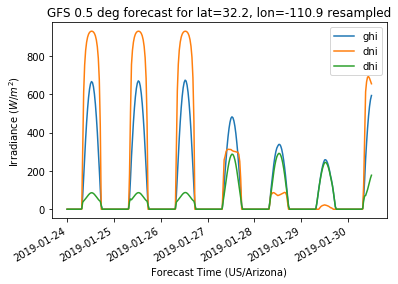

In [52]:
# resampled_data = data.resample('5min').interpolate()
resampled_data = data.resample('30min').interpolate()

resampled_irrads = model.cloud_cover_to_irradiance(resampled_data['total_clouds'], how='clearsky_scaling')
resampled_irrads.plot();
plt.ylabel('Irradiance ($W/m^2$)');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('GFS 0.5 deg forecast for lat={}, lon={} resampled'.format(latitude, longitude)); 
plt.legend();

Users may then recombine resampled_irrads and resampled_data using slicing pandas.concat() or pandas.DataFrame.join().

We reiterate that the open source code enables users to customize the model processing to their liking.

[Lar16]	Larson et. al. “Day-ahead forecasting of solar power output from photovoltaic plants in the American Southwest” Renewable Energy 91, 11-20 (2016).

[Liu60]	B. Y. Liu and R. C. Jordan, The interrelationship and characteristic distribution of direct, diffuse, and total solar radiation, Solar Energy 4, 1 (1960).

# PV Power Forecast

Finally, we demonstrate the application of the weather forecast data to a PV power forecast. Please see the remainder of the pvlib documentation for details.

In [53]:
from pvlib.pvsystem import PVSystem, retrieve_sam

from pvlib.tracking import SingleAxisTracker

from pvlib.modelchain import ModelChain

sandia_modules = retrieve_sam('sandiamod')

cec_inverters = retrieve_sam('cecinverter')

module = sandia_modules['Canadian_Solar_CS5P_220M___2009_']

inverter = cec_inverters['SMA_America__SC630CP_US_315V__CEC_2012_']

# model a big tracker for more fun
system = SingleAxisTracker(module_parameters=module,inverter_parameters=inverter, 
                           modules_per_string=15,strings_per_inverter=300)


In [54]:
# fx is a common abbreviation for forecast
fx_model = GFS()
fx_data = fx_model.get_processed_data(latitude, longitude, start, end)

# use a ModelChain object to calculate modeling intermediates
mc = ModelChain(system, fx_model.location)

# extract relevant data for model chain
mc.run_model(fx_data.index, weather=fx_data);

C:\Users\Mhdella\Anaconda3\lib\site-packages\pvlib\tracking.py:424: RuntimeWarning: invalid value encountered in minimum
  temp = np.minimum(axes_distance*cosd(wid), 1)
C:\Users\Mhdella\Anaconda3\lib\site-packages\pvlib\tracking.py:431: RuntimeWarning: invalid value encountered in less
  tracker_theta = np.where(wid < 0, wid + wc, wid - wc)
C:\Users\Mhdella\Anaconda3\lib\site-packages\pvlib\tracking.py:435: RuntimeWarning: invalid value encountered in greater
  tracker_theta[tracker_theta > max_angle] = max_angle
C:\Users\Mhdella\Anaconda3\lib\site-packages\pvlib\tracking.py:436: RuntimeWarning: invalid value encountered in less
  tracker_theta[tracker_theta < -max_angle] = -max_angle
C:\Users\Mhdella\Anaconda3\lib\site-packages\pvlib\tracking.py:543: RuntimeWarning: invalid value encountered in less
  surface_azimuth[surface_azimuth < 0] += 360
C:\Users\Mhdella\Anaconda3\lib\site-packages\pvlib\tracking.py:544: RuntimeWarning: invalid value encountered in greater_equal
  surface_azimu

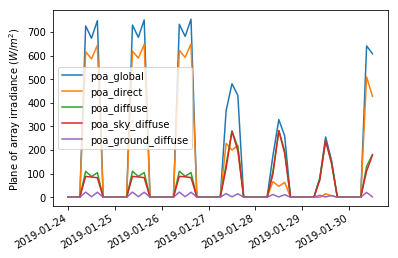

In [57]:
mc.total_irrad.plot();
plt.ylabel('Plane of array irradiance ($W/m^2$)');

plt.legend(loc='best');

…the cell and module temperature…

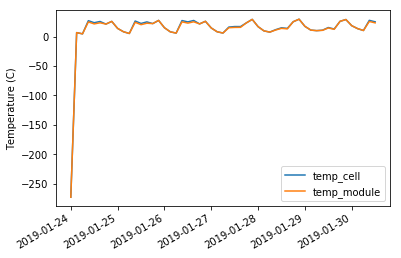

In [59]:
mc.temps.plot();
plt.ylabel('Temperature (C)');

…and finally AC power…

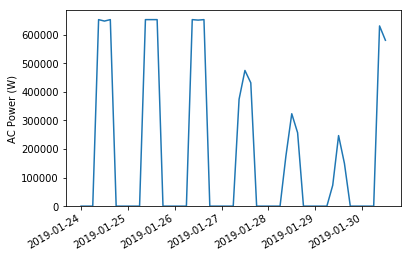

In [60]:
mc.ac.fillna(0).plot();

plt.ylim(0, None);

plt.ylabel('AC Power (W)');

In [61]:
mc.ac.fillna(0).describe()

count        53.000000
mean     180913.836571
std      265734.458460
min           0.000000
25%           0.000000
50%           0.000000
75%      374339.768792
max      653000.000000
dtype: float64